In [1]:
import os
import cv2  
import pandas as pd

In [2]:
# Define the paths to your image folders
healthy_folder_training = "Resources/heart_images/train/train_healthy"
healthy_folder_testing = "Resources/heart_images/test/test_healthy"
unhealthy_folder_training = "Resources/heart_images/train/train_unhealthy"
unhealthy_folder_testing = "Resources/heart_images/test/test_unhealthy"

# Function to read images from a folder and categorize them
def categorize_images(folder_path, category):
    image_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Assuming images are jpg or png
            image_path = os.path.join(folder_path, filename)
            # Read image using OpenCV 
            image = cv2.imread(image_path)  # For OpenCV
            # Append image data along with category to the list
            image_data.append({"Image_Path": image_path, "Category": category})
    return image_data

# Categorize healthy images
healthy_images_train = categorize_images(healthy_folder_training, "Healthy")
healthy_images_test = categorize_images(healthy_folder_testing, "Healthy")

# Categorize unhealthy images
unhealthy_images_train = categorize_images(unhealthy_folder_training, "Unhealthy")
unhealthy_images_test = categorize_images(unhealthy_folder_testing, "Unhealthy")

In [3]:
# Combine the test images
all_images_test = healthy_images_test + unhealthy_images_test

# Combine the training images
all_images_train = healthy_images_test + unhealthy_images_train

In [4]:
# Create a DataFrame from the test images combined list
df_test = pd.DataFrame(all_images_test)

In [5]:
# Create a DataFrame from the training images combined list
df_train = pd.DataFrame(all_images_train)

In [6]:
# Save test DataFrame to Excel file
excel_file_path_1 = "test_data.xlsx"
df_test.to_excel(excel_file_path_1, index=False)

print("Excel file saved successfully.")

Excel file saved successfully.


In [7]:
# Save training DataFrame to Excel file
excel_file_path_2 = "training_data.xlsx"
df_train.to_excel(excel_file_path_2, index=False)

print("Excel file saved successfully.")

Excel file saved successfully.


In [26]:
# Dependencies
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [27]:
# Load the VGG19 model
# https://keras.io/api/applications/vgg/#vgg19-function
model = VGG19(include_top=True, weights='imagenet')

In [28]:
# Define default image size for VGG19
image_size = (224, 224)

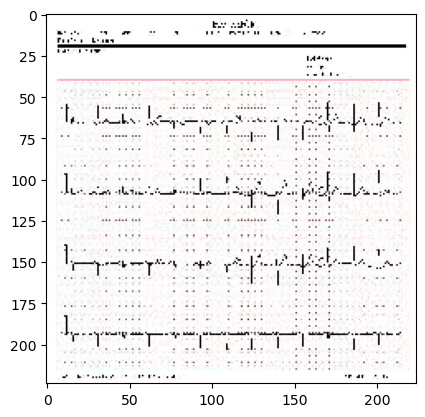

In [29]:
# Load the image and resize to default image size
image_path = "Resources/heart_images/train/train_healthy/Normal(143).jpg"
img = image.load_img(image_path, target_size=image_size)
plt.imshow(img)
plt.show()

In [30]:
# Preprocess image for model prediction
# This step handles scaling and normalization for VGG19
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [31]:
# Load the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [32]:
# Path for train, validation and test datasets
train_path = 'training_data.xlsx'
valid_path = 'training_data.xlsx'
test_path = 'test_data.xlsx'
IMAGE_SIZE = [224, 224] #Default image size for VGG16
folders = glob('training_data.xlsx*3') #Get number of classes

# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set.
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

#Through flow_from_directory - we create an array of images that can be used for training. 
training_set = train_datagen.flow_from_directory(
'training_data.xlsx',
                                                 target_size = (224, 224),
                                                 batch_size =465,
                                                 class_mode = 'categorical')
validation_set = validation_datagen.flow_from_directory('training_data.xlsx',
                                                 target_size = (224, 224),
                                                 batch_size = 465,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('test_data.xlsx',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

NotADirectoryError: [WinError 267] The directory name is invalid: 'training_data.xlsx'